In [1]:
import numpy as np
from numpy import random as rnd
from matplotlib import pyplot as plt
import os,datetime,time,warnings,sys,itertools,math

import pandas as pd

from plotly import express

import torch
import torch.nn as nn
import torch.nn.functional as F

from rdflib import Namespace,URIRef,Graph,Literal
from urllib.parse import quote

In [2]:
bf = pd.read_excel(
    io=r'D:\UserData\z003mxpm\gitdir\GITREPO\TF_Data\Dropbox\PhD Prep\SHS DQ\DQ Flags in CDC.xlsx',
    sheet_name='DQ Checks'
)

In [3]:
df = bf[
    (bf['Domain']=='Opportunity')&
    ((bf['Table']=='OLIs')|(bf['Table']=='Opportunities'))&
    (bf['Type']=='DQ Flag')&
    (~bf['Name'].str.startswith('Rule'))
]

df = df[[
#    'Domain', 
#    'Table', 
#    'Schema', 
    'Name', 
#    'Type', 
#    'Criterion',
    'Reported In (Main Source)', 
#    'Original Method of Definition',
    'First Calculation', 
#    'Dimension',
#    'Hard Error - more of a warning (N) or a real DQ Error (Y) (Flag)',
#    'Check Outdated (Flag)', 
#    'Outside of CDC Scope (Flag)', 
#    'Comment',
#    'Business Definition', 
#    'Currently Active (Flag)', 
#    'Scope Limitations',
#    'Associated Checkpoint ID'
]]

In [4]:
# Flags dataframe with link keys
df_flags = df.set_index(['Name','First Calculation']).apply(lambda x: x.str.split(', ').explode()).reset_index().rename(columns={'Name':'Flag Name'})

# Other linked entities
df_calc = df_flags[['First Calculation']].dropna().drop_duplicates().rename(columns={'First Calculation':'Calculation Location'})
df_rep = df_flags[['Reported In (Main Source)']].dropna().drop_duplicates().rename(columns={'Reported In (Main Source)':'Reporting Location'})

In [5]:
EG = Namespace('http://dqflags.com/')
def create_eg_uri(name:str) -> URIRef:
    quoted_str = quote(name.replace(' ','_'),safe='')
    return EG[quoted_str]

In [62]:
# Initialize the graph

graph = Graph()

In [63]:
predicate_cols = ['First Calculation','Reported In (Main Source)']

In [64]:
for k,v in df_flags.iterrows():
    vv = dict(v)
    subject = vv['Flag Name']
    for predicate in predicate_cols:
        object = vv[predicate]
        if isinstance(object,str):
            object = object.strip()
        if not pd.isnull((object)):
            subject_uri = create_eg_uri(subject)
            predicate_uri = create_eg_uri(predicate)
            object_uri = create_eg_uri(object)
            graph.add((subject_uri,predicate_uri,object_uri))

In [66]:
url = 'https://www.w3.org/TeamSubmission/turtle/tests/test-30.ttl'

In [74]:
result = graph.parse('D:\\UserData\\z003mxpm\\Desktop\\xyz.ttl',format='turtle')

D:\UserData\z003mxpm\Desktop\xyz.ttl does not look like a valid URI, trying to serialize this will break.


URLError: <urlopen error unknown url type: d>

In [69]:
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
import networkx as nx

In [70]:
G = rdflib_to_networkx_multidigraph(result)

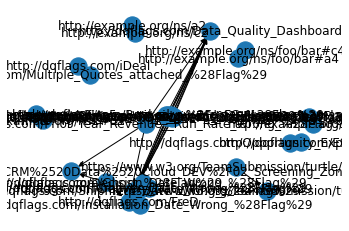

In [72]:
pos = nx.spring_layout(G,scale=2)
edge_labels = nx.get_edge_attributes(G,'r')
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)

nx.draw(G,with_labels=True)

In [82]:
graph.objects

<bound method Graph.objects of <Graph identifier=N000e1478c4e3457e8b8521ca8f6fafd3 (<class 'rdflib.graph.Graph'>)>>